In [ ]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Chỉ định từng đường dẫn

In [ ]:
dataset = 'point_history.csv'
model_save_path = 'point_history_classifier.hdf5'

# Cài đặt số phân loại

In [ ]:
NUM_CLASSES = 4

# Độ dài đầu vào

In [ ]:
TIME_STEPS = 16
DIMENSION = 2

# Đọc dữ liệu đào tạo

In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Xây dựng mô hình

In [ ]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True),input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 24)                792       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                250       
                                                                 
 dense_4 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# callback model
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=500, verbose=1)

In [ ]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=512,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.2398
Epoch 1: saving model to point_history_classifier.hdf5
1/1 [==============================] - 0s 463ms/step - loss: 1.3893 - accuracy: 0.2398 - val_loss: 1.4106 - val_accuracy: 0.2703
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 1.3872 - accuracy: 0.2534
Epoch 2: saving model to point_history_classifier.hdf5
1/1 [==============================] - 0s 44ms/step - loss: 1.3872 - accuracy: 0.2534 - val_loss: 1.4070 - val_accuracy: 0.2703
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 1.3885 - accuracy: 0.2805
Epoch 3: saving model to point_history_classifier.hdf5
1/1 [==============================] - 0s 49ms/step - loss: 1.3885 - accuracy: 0.2805 - val_loss: 1.4035 - val_accuracy: 0.2703
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 1.3943 - accuracy: 0.2534
Epoch 4: saving model to point_history_classifier.hdf5
1/1 [==============

In [ ]:
# Đang tải mô hình đã lưu
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Kiểm tra suy luận
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.37758166 0.53494173 0.04030369 0.04717291]
1


# Confix matrix

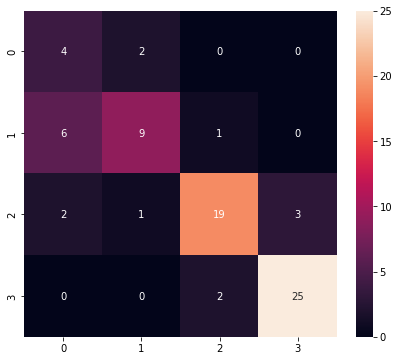

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         6
           1       0.75      0.56      0.64        16
           2       0.86      0.76      0.81        25
           3       0.89      0.93      0.91        27

    accuracy                           0.77        74
   macro avg       0.71      0.73      0.70        74
weighted avg       0.81      0.77      0.78        74



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite convert

In [ ]:

model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [ ]:
tflite_save_path = 'point_history_classifier.tflite'

In [ ]:
# 
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp1v6qu5d4/assets


INFO:tensorflow:Assets written to: /tmp/tmp1v6qu5d4/assets


6320

# Kiểm tra suy luận

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 401 µs, sys: 31 µs, total: 432 µs
Wall time: 322 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.37758166 0.5349418  0.04030369 0.04717291]
1
